In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

In [2]:
X, y = load_boston().data, load_boston().target.reshape(-1,1)

In [3]:
X.shape, y.shape

((506, 13), (506, 1))

In [4]:
class NN_Build(object):
    def __init__(self, eta = 0.0005, iterations = 1000, activation = "relu", epsilon = 0.01, kernel_init = 'he_init', 
                 dims = [X.shape[1],30,5,1], lam = 0.9, beta = 0.9, epsilon_beta = 0.0000000001):
        self.eta = eta
        self.iterations = iterations
        self.activation = activation
        self.epsilon = epsilon
        self.kernel_init = kernel_init
        self.dims = dims
        self.layer = len(dims)
        self.lam = lam
        self.beta = beta
        self.epsilon_beta = epsilon_beta
        
    def fit(self,X,y):
        X_ = X.T
        y_ = y.T
        A0 = X_
        i = 1
        m_ = len(y)
        parameters = {}
        cost_ = []
        cost_mae_ = []
        sdW3 = 0
        sdb3 = 0
        sdW2 = 0
        sdb2 = 0
        sdW1 = 0
        sdb1 = 0
        
        if self.kernel_init == "he_init":
            for l in range(1,self.layer):
                parameters['W'+str(l)] = np.random.randn(self.dims[l],self.dims[l-1])  * np.sqrt(2/self.dims[l-1]) 
                parameters['b' + str(l)] = np.zeros((self.dims[l],1)) 
            print('kernel_init is he_init')
        else:
            for l in range(1,self.layer):
                parameters['W'+str(l)] = np.random.randn(self.dims[l],self.dims[l-1])  * self.epsilon
                parameters['b' + str(l)] = np.zeros((self.dims[l],1)) 
            print('kernel_init is random nd')
        
        while(i !=self.iterations+1):
            #forward prop
            Z1 = np.dot(parameters['W1'],A0) + parameters['b1']
            if self.activation == "relu":
                A1 = self.relu(Z1)
            else:
                A1 = self.sigmoid(Z1)
            Z2= np.dot(parameters['W2'],A1) + parameters['b2']
            if self.activation == "relu":
                A2 = self.relu(Z2)
            else:
                A2 = self.sigmoid(Z2)
            Z3 = np.dot(parameters['W3'],A2) + parameters['b3']
            A3 = Z3            
            #cost
            l2_reg = (self.lam/(2*m_)) * (np.sum(np.square(parameters['W1']))+np.sum(np.square(parameters['W2']))+np.sum(np.square(parameters['W3'])))
            cost = self.MSE(y_true = y_, y_pred = A3 , n = m_) + l2_reg
            cost_.append(cost)
            cost_mae = self.MAE(y_true = y_, y_pred = A3 , n = m_) + l2_reg
            cost_mae_.append(cost_mae)           
            #derivative
            dZ3 = A3 - y_
            dW3 = (1/m_) * np.dot(dZ3,A2.T) + (self.lam/m_) * parameters['W3']
            db3 = (1/m_) * np.sum(dZ3, axis = 1, keepdims= True)
            if self.activation == 'relu':
                dZ2 = np.dot(parameters['W3'].T,dZ3) * (np.where(A2>=0,1,0))
            else:
                dZ2 = np.dot(parameters['W3'].T,dZ3) * (A2 * (1-A2))
            dW2 = (1/m_) * np.dot(dZ2,A1.T) + (self.lam/m_) * parameters['W2']
            db2 = (1/m_) * np.sum(dZ2, axis = 1, keepdims= True)
            if self.activation == 'relu':
                dZ1 = np.dot(parameters['W2'].T,dZ2) * (np.where(A1>=0,1,0))
            else:
                dZ1 = np.dot(parameters['W2'].T,dZ2) * (A1 * (1-A1))
            dW1 = (1/m_) * np.dot(dZ1,A0.T) + (self.lam/m_) * parameters['W1']
            db1 = (1/m_) * np.sum(dZ1, axis = 1, keepdims= True)
            #sdwb
            sdW3 = self.beta * sdW3 + (1- self.beta) * dW3 **2
            sdb3 = self.beta * sdb3 + (1- self.beta) * db3 **2
            sdW2 = self.beta * sdW2 + (1- self.beta) * dW2 **2
            sdb2 = self.beta * sdb2 + (1- self.beta) * db2 **2
            sdW1 = self.beta * sdW1 + (1- self.beta) * dW1 **2
            sdb1 = self.beta * sdb1 + (1- self.beta) * db1 **2
            #update
            parameters['W3'] -= self.eta * dW3 / np.sqrt(sdW3 + self.epsilon_beta)
            parameters['W2'] -= self.eta * dW2 / np.sqrt(sdW2+ self.epsilon_beta)
            parameters['W1'] -= self.eta * dW1 / np.sqrt(sdW1+ self.epsilon_beta)
            parameters['b3'] -= self.eta * db3 / np.sqrt(sdb3+ self.epsilon_beta)
            parameters['b2'] -= self.eta * db2 / np.sqrt(sdb2+ self.epsilon_beta)
            parameters['b1'] -= self.eta * db1 / np.sqrt(sdb1+ self.epsilon_beta)
            #inform
            if i % 200 == 0:
                print('epoch_{} cost: {}  mae: {}'.format(i,cost,cost_mae))
            
            i += 1
            
        history = pd.DataFrame(cost_, columns = ['cost'])
        history['mae'] = cost_mae_
        plt.figure(figsize = (14,4))
        plt.subplot(1,2,1)
        plt.plot(history.cost)
        plt.subplot(1,2,2)
        plt.plot(history.mae)
        return parameters,A3,A2
    
    def sigmoid(self,z):
        return 1 / (1+ np.exp(-z))
    
    def relu(self,z):
        return np.where(z>=0,z,0)
    
    def MSE(self,y_true,y_pred,n):
        return (1/n) * np.sum(np.square(y_true-y_pred))
    
    def MAE(self,y_true,y_pred,n):
        return (1/n) * np.sum(np.abs(y_true-y_pred))
        
        

kernel_init is he_init
epoch_200 cost: 55867.5168147267  mae: 225.2931735305751
epoch_400 cost: 26011.803191938954  mae: 154.22705807513253
epoch_600 cost: 6585.451141240176  mae: 75.79941785170074
epoch_800 cost: 489.1545580565601  mae: 17.5617323798967
epoch_1000 cost: 350.3631061926704  mae: 14.886052366158895
epoch_1200 cost: 263.7174188636548  mae: 12.58111115632829
epoch_1400 cost: 204.53499225084815  mae: 10.778899721586976
epoch_1600 cost: 167.17646422971  mae: 9.567717551011777
epoch_1800 cost: 143.50309437810225  mae: 8.742666291876132
epoch_2000 cost: 126.23653309692588  mae: 8.116388532233977
epoch_2200 cost: 112.92998465419461  mae: 7.600803064987415
epoch_2400 cost: 102.39061024416937  mae: 7.182646901000453
epoch_2600 cost: 93.92946311625924  mae: 6.856699084658441
epoch_2800 cost: 86.71140302426639  mae: 6.563108379146256
epoch_3000 cost: 80.21822907280621  mae: 6.293350323678439
epoch_3200 cost: 74.29986284090927  mae: 6.044948266755206
epoch_3400 cost: 68.846499681723

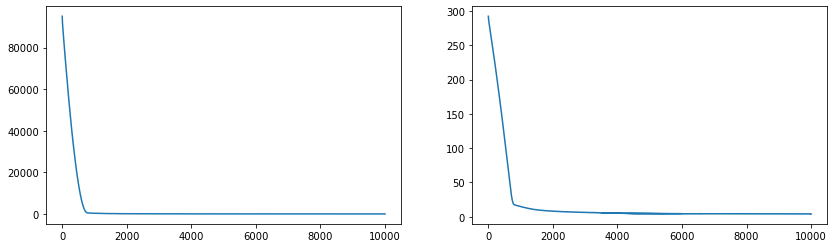

In [5]:
parameters, A3, A2 = NN_Build(eta=0.00005,
    iterations=10000,
    activation='relu',
    epsilon=0.01,
    kernel_init='he_init',
    dims=[13, 30, 10, 1],
    lam = 0.9).fit(X,y)

In [6]:
A2.shape

(10, 506)

In [7]:
A3.shape

(1, 506)

In [8]:
A2.T

array([[  0.        ,  78.6527519 ,  41.14931445, ...,   0.        ,
        114.14481339,  32.38011124],
       [  0.        ,  65.19630197,  21.44681372, ...,   0.        ,
        147.37739183,  21.19504938],
       [  0.        ,  61.51487306,  20.00951356, ...,   0.        ,
        142.90120927,  15.94411237],
       ...,
       [  0.        ,  78.21442029,  32.70146631, ...,   0.        ,
        139.56991062,  32.90333726],
       [  0.        ,  77.44620223,  33.1030791 , ...,   0.        ,
        136.60257693,  34.42912113],
       [  0.        ,  73.83352908,  30.21895582, ...,   0.        ,
        136.3783221 ,  34.94358333]])

(-1.0, 1.0)

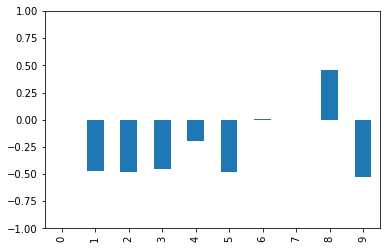

In [9]:
pd.DataFrame(np.hstack([A2.T,y])).corr().fillna(0).iloc[10,:10].plot(kind = 'bar')
plt.ylim(-1,1)

In [10]:
b = np.array([[3,4],[1,2]])

In [11]:
b ** 2

array([[ 9, 16],
       [ 1,  4]])